## Create Graph Plots of the Vector Images in Tempest

The graphics in Tempest are generated using Atari's 'Quadrascan' vector technology. The images are all defined using a series of vectors. A vector in this case is an `(x,y)` value pair that moves the beam in an x,y direction to a new point on the screen. A series of vectors moving from point to point around the screen will eventually form a complete image.

There are a bunch of different macros used to encode the vector commands that define the images. Most of the image definitions appear in `ALVROM.MAC`, and a few others in `ALDIS2.MAC`.


[This page](https://arcarc.xmission.com/Tech/neilw_xy.txt) gives a good overview of the different vector commands.

Here is an example of a vector command in action. There are two types of commands for drawing a vector. The first we'll cover is the simplest:

```
Bit Key:

          X - X coordinate bits
          Y - Y coordinate bits
          I - Vector intensity(brightness) bits
          
Draw short relative vector 0x40     010YYYYY IIIXXXXX
```

This command draws a line from the beam's current position by moving it to the X,Y position specified by the vector command. The brightness of the line is specified by the intensity bits.

For example if X is 0, Y is 16, and our intensity value is 6. We would encode this as follows:

```
    16    6    0
010 10000 110  00000
```
This gives us a hex value of 48C0.

Here we have a snippet from the assembly listing of `ANVGAN.MAC`, where the vectors for all the alphanumerics used in Tempest are defined. This is the letter `A` specified by a series of vector commands. On the left hand side are encoded vector commands, on the right hand side are the assembly statements they have been assembled from. 

```
     3+  3000  48C0                     CHAR.A: VCTR 0,16,.BRITE
     4+  3002  44C4                             VCTR 8,8,.BRITE
     5+  3004  5CC4                             VCTR 8,-8,.BRITE
     6+  3006  58C0                             VCTR 0,-16,.BRITE
     7+  3008  4418                             VCTR -16,8,0
     8+  300A  40C8                             VCTR 16,0,.BRITE
     9+  300C  5C04                             VCTR 8,-8,0
```
`VCTR` is a macro that looks as follows:
```asm
	.MACRO	VCTR DX,DY,ZZ
	...1=DX
	...2=DY
	.IF	 LT,...1		;IF NEGATIVE X
	...1=-DX
	.ENDC
	.IF	 LT,...2		;IF NEGATIVE Y
	...2=-DY
	.ENDC
	...5=...1!...2
	.IF	NE,...1+...2			;IF X AND Y ARE 0 - SKIP SHOR VECTOR
	.IF	 EQ,...5&^H0FFE1
	.WORD	^H4000+<ZZ*^H20>+<DX/2&^H1F>+<DY*^H80&^H1F00>
	.MEXIT
	.ENDC
	.ENDC
	.WORD	DY&^H1FFF,<ZZ*^H2000>+<DX&^H1FFF>
	.ENDM
```

`VCTR` takes three arguments: X,Y, and intensity. In the following python snippet we emulate its operation to encode the three arguments into the appropriate two-byte vector command.

In [59]:
import tabulate
vecs = [(x.split()[2],x.split()[-1].replace(".BRITE","6")) 
     for x in """
     3+  3000  48C0                     CHAR.A: VCTR 0,16,.BRITE
     4+  3002  44C4                             VCTR 8,8,.BRITE
     5+  3004  5CC4                             VCTR 8,-8,.BRITE
     6+  3006  58C0                             VCTR 0,-16,.BRITE
     7+  3008  4418                             VCTR -16,8,0
     8+  300A  40C8                             VCTR 16,0,.BRITE
     9+  300C  5C04                             VCTR 8,-8,0
""".splitlines()[1:]]

data=[["Original","Parms","Calculated"]]
for fvec, rvec in vecs:
    x,y,i = [int(x) for x in rvec.split(',')]
    cvec = 0x4000
    cvec += i * 0x20
    cvec += int(abs(x)/2) & 0x1F
    if x < 0:
        cvec |= 0x10
    cvec += (y*0x80) & 0x1F00
    if y < 0:
        cvec |= 0x1000
    data +=[[fvec,rvec,hex(cvec)]]

table = tabulate.tabulate(data, tablefmt='html')
table


Original,Parms,Calculated
48C0,"0,16,6",0x48c0
44C4,"8,8,6",0x44c4
5CC4,"8,-8,6",0x5cc4
58C0,"0,-16,6",0x58c0
4418,"-16,8,0",0x4418
40C8,"16,0,6",0x40c8
5C04,"8,-8,0",0x5c04


Let's decode some vector commands into line graphs. Here are the functions we'll use to do this. They will take the raw assembly commands from the Tempest source listing and convert them into line-graphs that show us the images they encode.

Our end result in each case is a graph of x,y vertices that form the image in question.

In [60]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)

def plot_vertices_imgonly(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.axis('off')
    plt.savefig(f"vector_images/vec_image_{file_name}.png", bbox_inches='tight')

def tabulateVecsAndVerts(vectors,vertices):
    data =[["Vector X", "Vector Y", "Vertex X", "Vertex Y"]]
    for (vx,vy,_),(x,y,_) in zip(vectors,vertices):
        data +=[[str(vx),str(vy),str(x),str(y),]]
    table = tabulate.tabulate(data, tablefmt='html')
    return table

## Images from ALVROM.MAC

These are all the other images used by the game, including title text. We start with an interesting find: unused prototypes for the player's claw!

## Unused Pictures in ALVROM.MAC

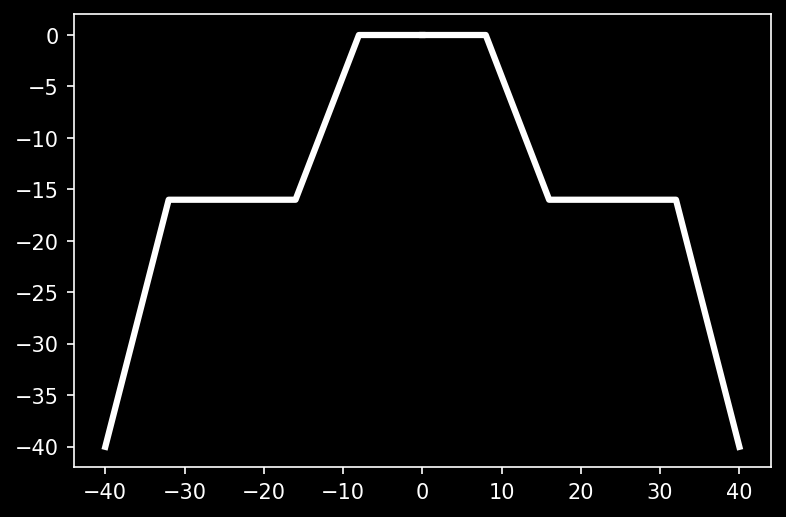

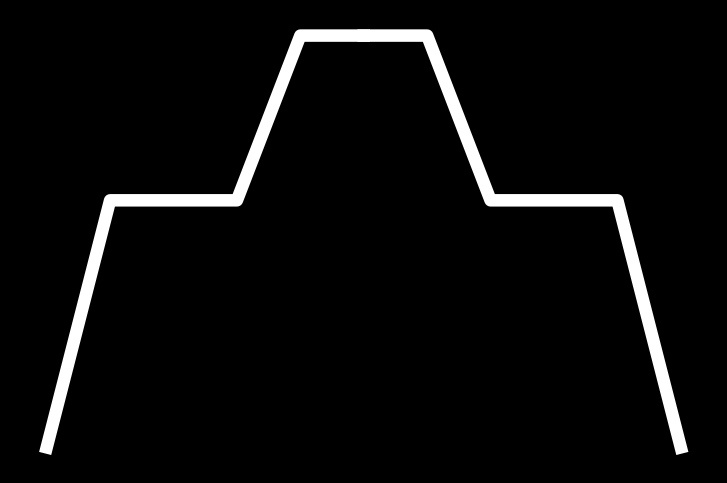

In [114]:
vector_data = """
GUNPIC:
    VCTR 0,0,6
    VCTR -8,0,6
	VCTR -8,-10,6
	VCTR -10,0,6
	VCTR -8,-18,6
	VCTR 50,0,0
	VCTR -8,18,6
	VCTR -10,0,6
	VCTR -8,10,6
	VCTR -8,0,6
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)
plot_vertices_imgonly(vertices,"gunpic",points="",linewidth=6.0)


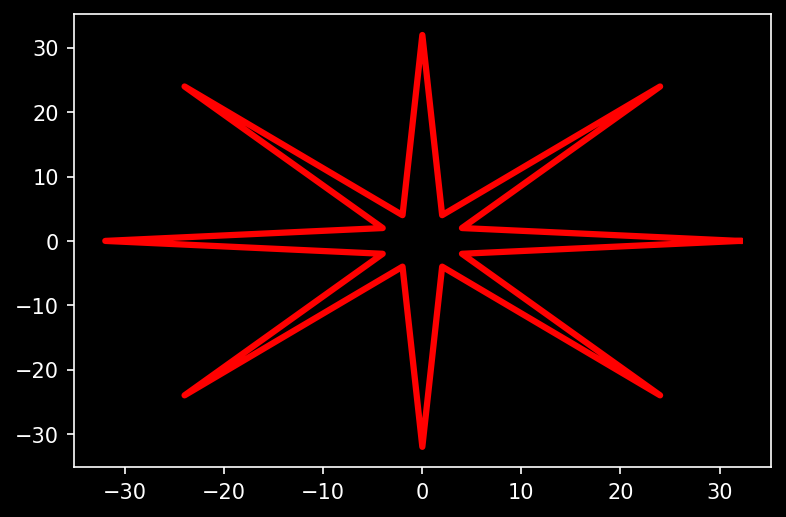

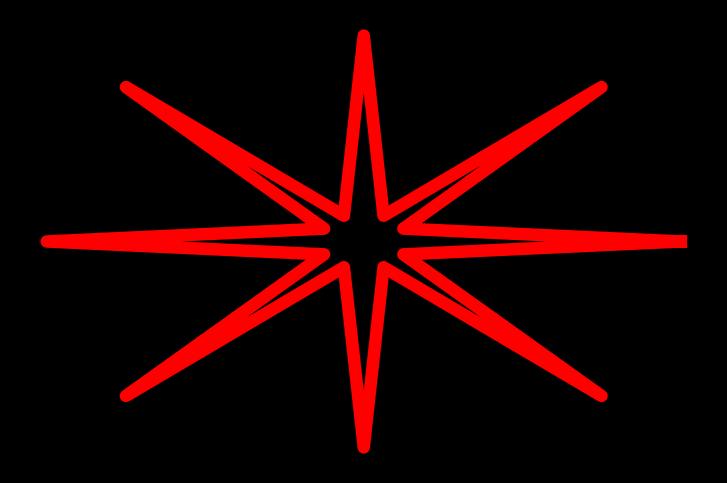

In [115]:
vector_data = """
EXPLOP:
	ICALVE
	.BRITE=0
	CALVEC 20.,0
	.BRITE=VARBRT
	CALVEC 4,2
	CALVEC 18.,18.
	CALVEC 2,4
	CALVEC 0,20.
	CALVEC -2,4
	CALVEC -18.,18.
	CALVEC -4,2
	CALVEC -20.,0
	CALVEC -4,-2
	CALVEC -18.,-18.
	CALVEC -2,-4
	CALVEC 0,-20.
	CALVEC 2,-4
	CALVEC 18.,-18.
	CALVEC 4,-2
	CALVEC 20.,0
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)
plot_vertices_imgonly(vertices,"explop",points="",linewidth=6.0)

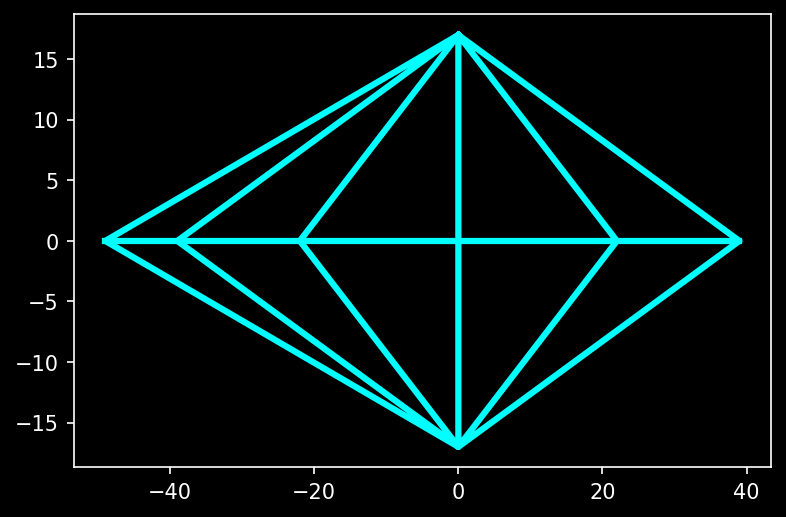

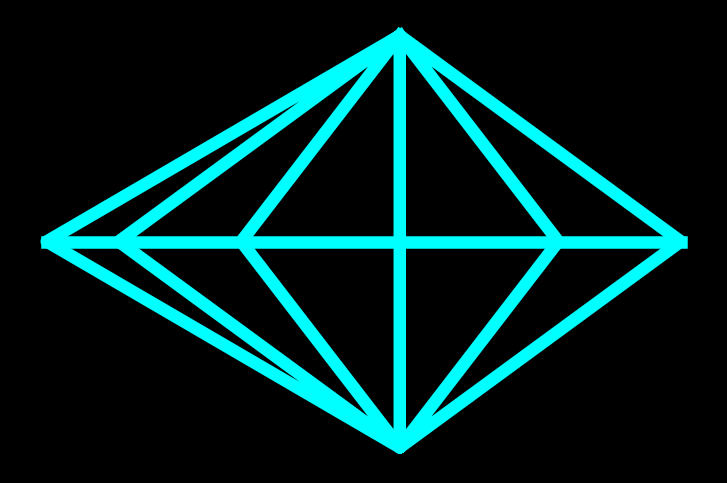

In [116]:
# HIGH=11
msauce_macro = """
.MACRO MSAUCE ...P1,...P2,...P3,...P4,...P5,...P6
	ICALVE
	CALVEC 0,.HIGH
	.BRITE=VARBRT
	CALVEC ...P1,0
	CALVEC 0,-.HIGH
	CALVEC ...P2,0
	CALVEC 0,.HIGH
	CALVEC ...P3,0
	CALVEC 0,-.HIGH
	CALVEC ...P4,0
	CALVEC 0,.HIGH
	CALVEC ...P5,0
	CALVEC 0,-.HIGH
	CALVEC ...P6,0
	CALVEC 0,.HIGH
	.BRITE=0
	CALVEC ...P6,0
	.BRITE=VARBRT
	CALVEC ...P1,0
	RTSL
"""

def_data = """
SAUPIC:	MSAUCE -31.,-27.,-16.,0,16.,27.
"""

def resolve_data(def_data):
    pic = msauce_macro
    pic = pic.replace("HIGH","11")
    parms = [x.replace('.','') for x in def_data.split()[2].split(',')]
    for i,x in enumerate(parms):
        pic = pic.replace(f"...P{i+1}",x)
    return pic

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")
plot_vertices_imgonly(vertices,"msauce",points="",linewidth=6.0)

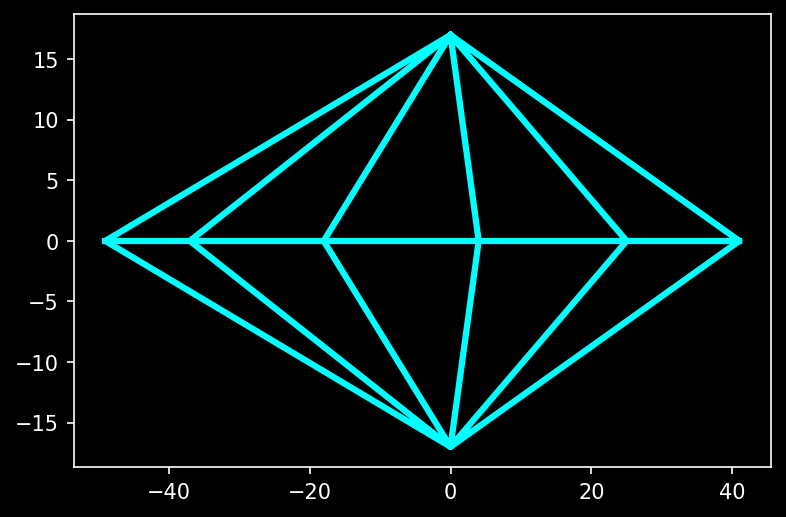

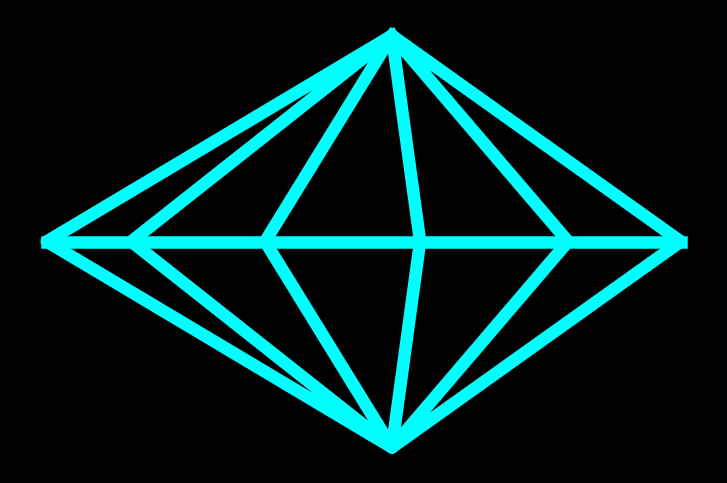

In [117]:
def_data = """
SA2PIC:	MSAUCE -31.,-25.,-12.,4,19.,29.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")
plot_vertices_imgonly(vertices,"sa2pic",points="",linewidth=6.0)

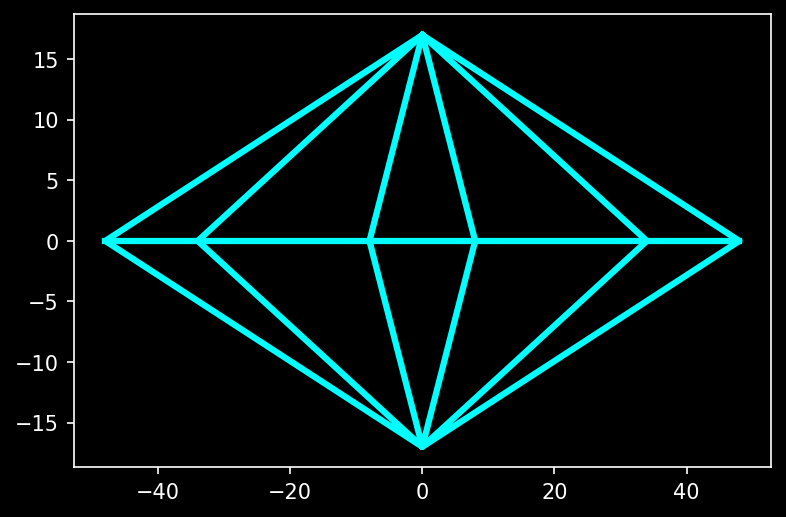

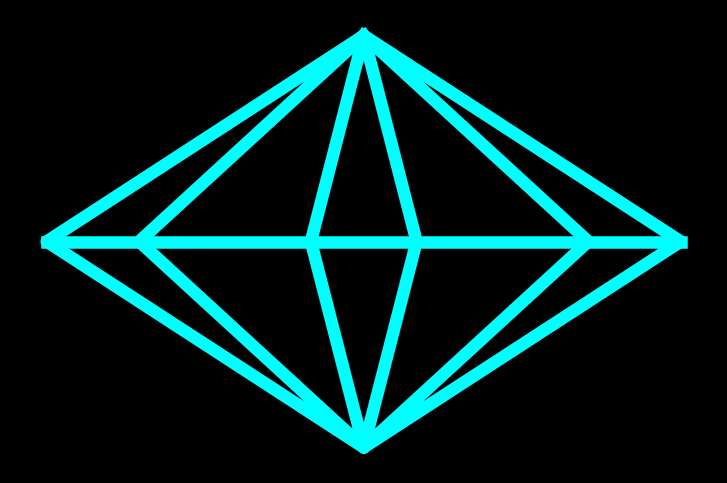

In [118]:
def_data = """
SA3PIC:
	MSAUCE -30.,-22.,-8,8,22.,30.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")
plot_vertices_imgonly(vertices,"sa3pic",points="",linewidth=6.0)

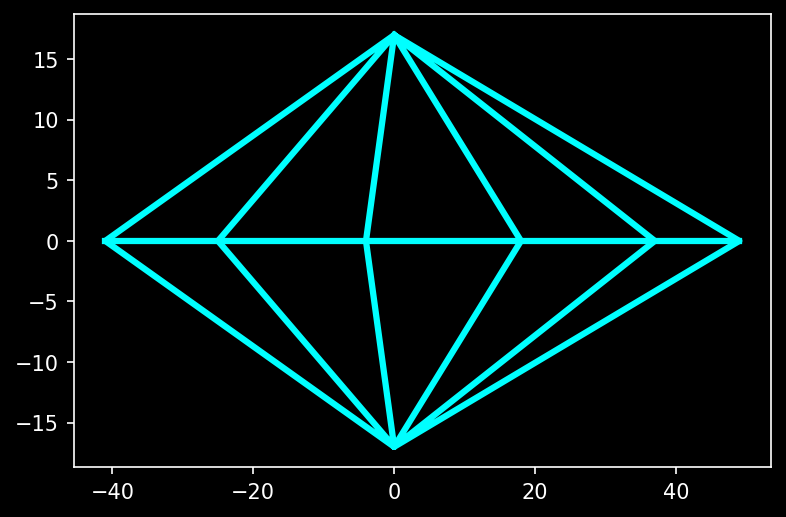

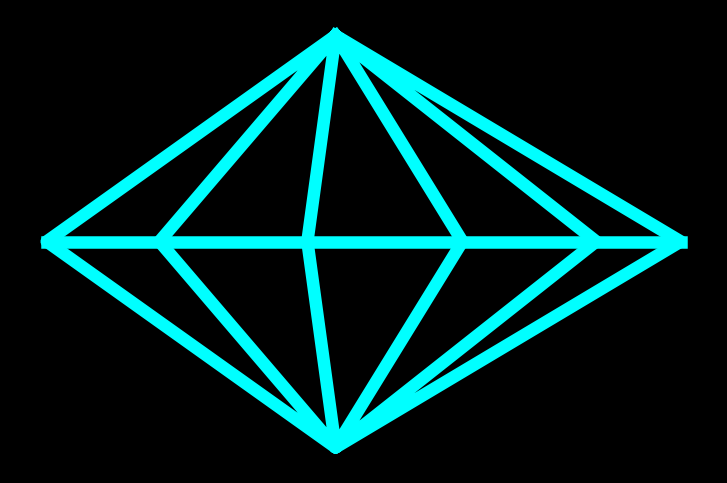

In [119]:
def_data = """
SA4PIC:
	MSAUCE -29.,-19.,-4,12.,25.,31.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")
plot_vertices_imgonly(vertices,"sa4pic",points="",linewidth=6.0)

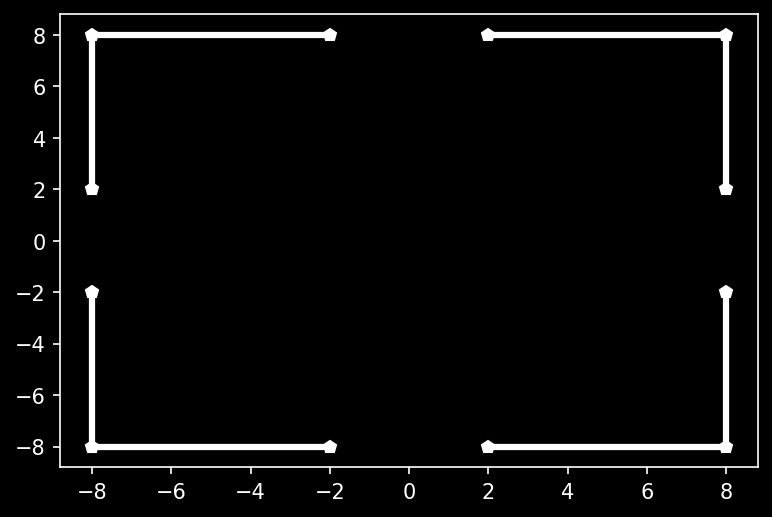

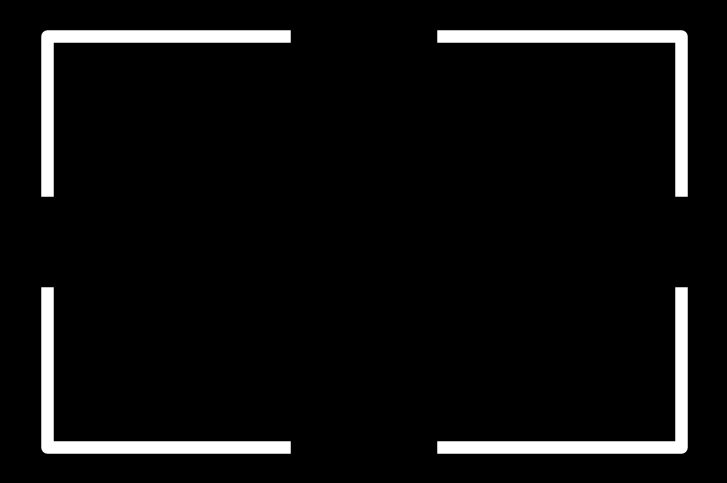

In [120]:
GURAD	="8"
GUBAR	="6"
GUBL	="4"
vector_data = """
GU2PIC:	
	CNTR
	VCTR GURAD,2,0
	VCTR 0,GUBAR,6
	VCTR -GUBAR,0,6
	VCTR -GUBL,0,0
	VCTR -GUBAR,0,6
	VCTR 0,-GUBAR,6
	VCTR 0,-GUBL,0
	VCTR 0,-GUBAR,6
	VCTR GUBAR,0,6
	VCTR GUBL,0,0
	VCTR GUBAR,0,6
	VCTR 0,GUBAR,6
	RTSL
""".replace("GUBAR",GUBAR).replace("GURAD",GURAD).replace("GUBL",GUBL)

vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")
plot_vertices_imgonly(vertices,"sa2pic",points="",linewidth=6.0)

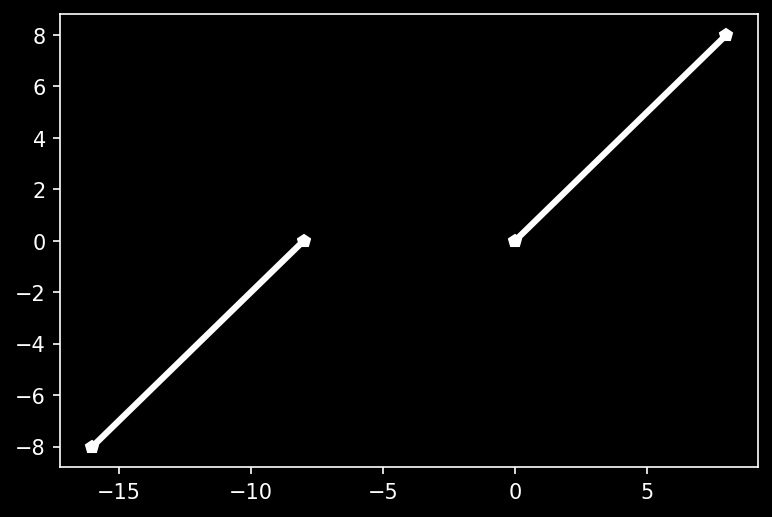

In [121]:
GURAD	=8
GUBAR	=6
GUBL	=4
vector_data = ("""
GU3PIC:
	CNTR
	VCTR GURAD,GURAD,0
	VCTR -2*GURAD,-2*GURAD,6
	VCTR 2*GURAD,0,0
	VCTR -2*GURAD,2*GURAD,6
	RTSL
""".replace("-2*GURAD",str(-1*GURAD))
   .replace("2*GURAD",str(-1*GURAD))
   .replace("GUBAR",str(GUBAR)).replace("GURAD",str(GURAD))
   .replace("GUBL",str(GUBL)))

vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


[21, 16, 14, 12]


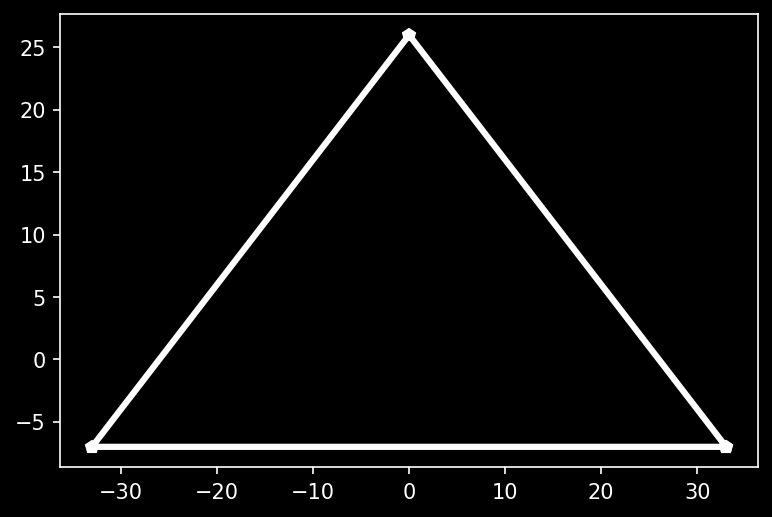

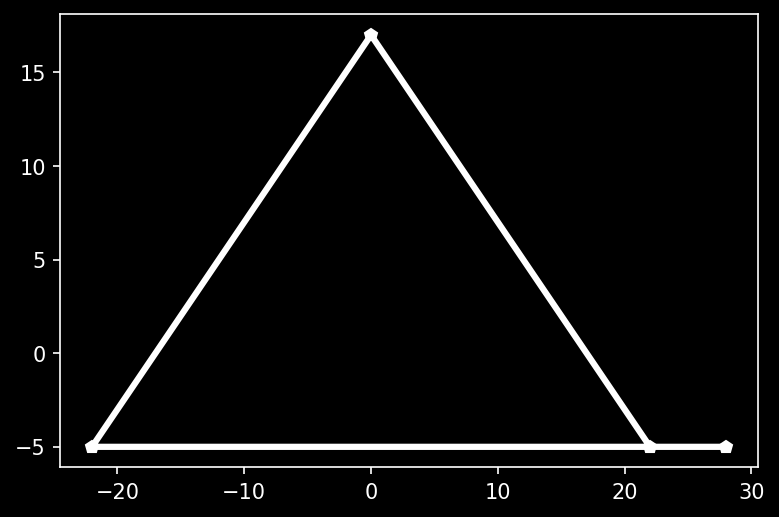

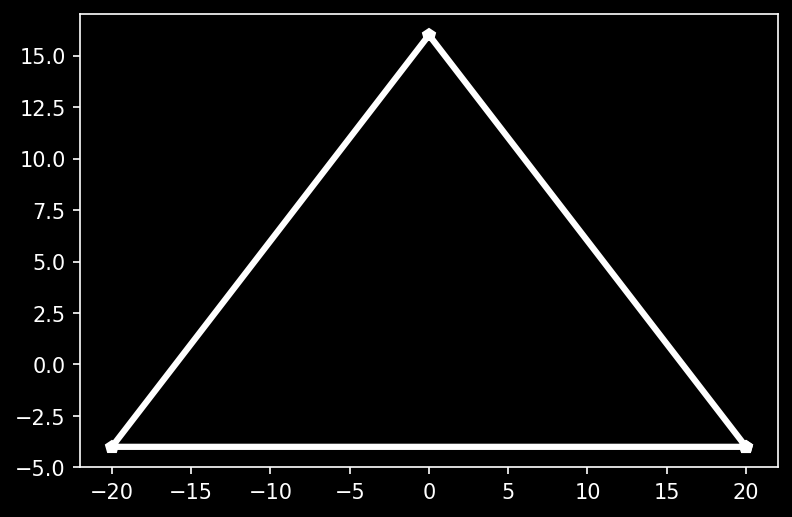

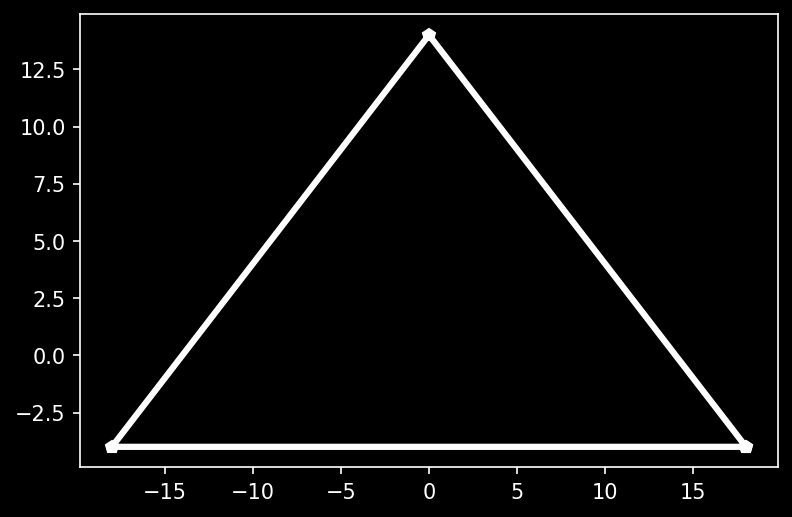

In [122]:

macro_data = """
.MACRO FORTMAC .FS
VCTR .FS,-<.FS/3>,0
VCTR -.FS,.FS,6
VCTR -.FS,-.FS,6
VCTR 2*.FS,0,6
VCTR -.FS,<.FS/3>,0
RTSL
.ENDM
.IF NE,0
"""

fort_data = """
FROW0: FORTMAC 15
FROW1: FORTMAC 10
FROW2: FORTMAC 0E
FROW3: FORTMAC 0C
"""
FSS = [int(x.split()[2],16) for x in fort_data.splitlines()[1:]]
print(FSS)
for FS in FSS:
    vector_data = (
        macro_data.replace("<.FS/3>", str(int(FS/3)))
       .replace("2*.FS", str(int(2*FS)))
       .replace(".FS", str(FS))
    )
    vectors = parse_vector_commands(vector_data,default_color="red")
    vertices = vectors_to_coords(vectors)
    plot_vertices(vertices,"p")


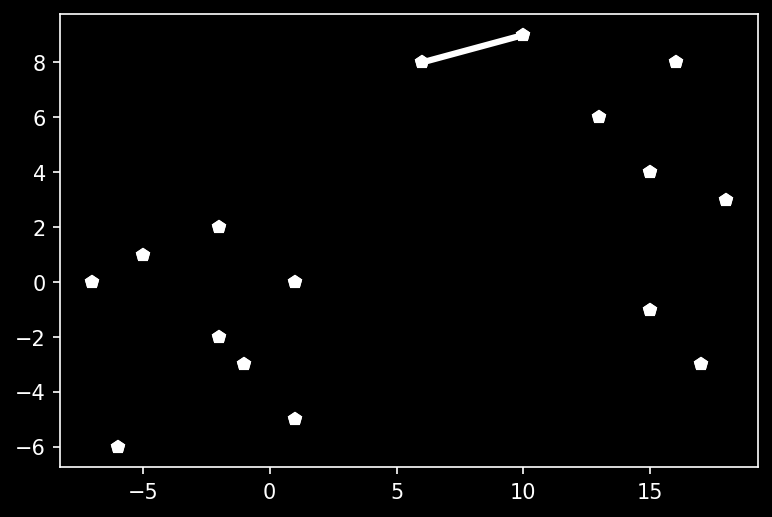

In [123]:
vector_data = """
SHRPIC:
	VCTR 1,0,0
	VDOT
	VCTR -3,2,0
	VDOT
	VCTR -3,-1,0
	VDOT
	VCTR -2,-1,0
	VDOT
	VCTR 1,-6,0
	VDOT
	VCTR 4,4,0
	VDOT
	VCTR 1,-1,0
	VDOT
	VCTR 2,-2,0
	VDOT
	VCTR 0E,4,0
	VDOT
	VCTR 2,-2,0
	VDOT
	VCTR 1,6,0
	VDOT
	VCTR -3,1,0
	VDOT
	VCTR -2,2,0
	VDOT
	VCTR 3,2,0
	VDOT
	VCTR -6,1,0
	VDOT
	VCTR -4,-1,6
	VDOT
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


## Images from ANVGAN.MAC

This file contains the vectors for all alphanumerics. The values given are decimal rather than hexadecimal.

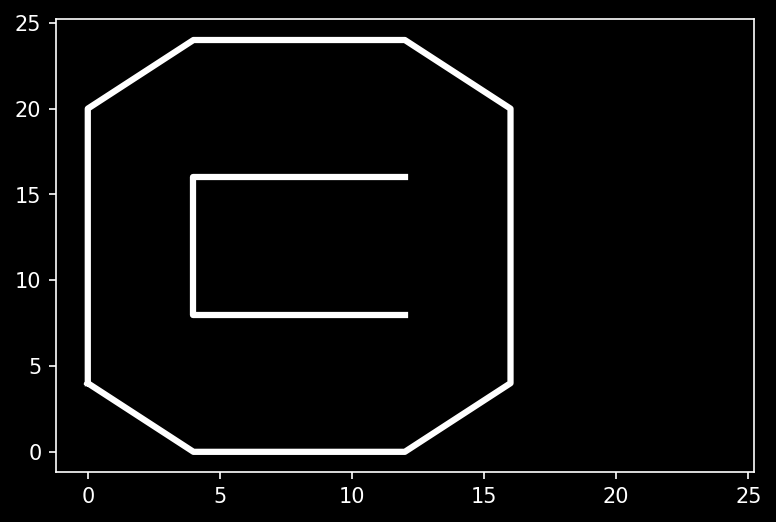

In [124]:
def vctr(color,x,y,i=""):
    x,y=int(x),int(y)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

vector_data = """
COPYR:
	VCTR 0,4,0
	VCTR 0,16,.BRITE
	VCTR 4,4,.BRITE
	VCTR 8,0,.BRITE
	VCTR 4,-4,.BRITE
	VCTR 0,-16,.BRITE
	VCTR -4,-4,.BRITE
	VCTR -8,0,.BRITE
	VCTR -4,4,.BRITE
	VCTR 12,4,0
	VCTR -8,0,.BRITE
	VCTR 0,8,.BRITE
	VCTR 8,0,.BRITE
	VCTR 12,-16,0
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)

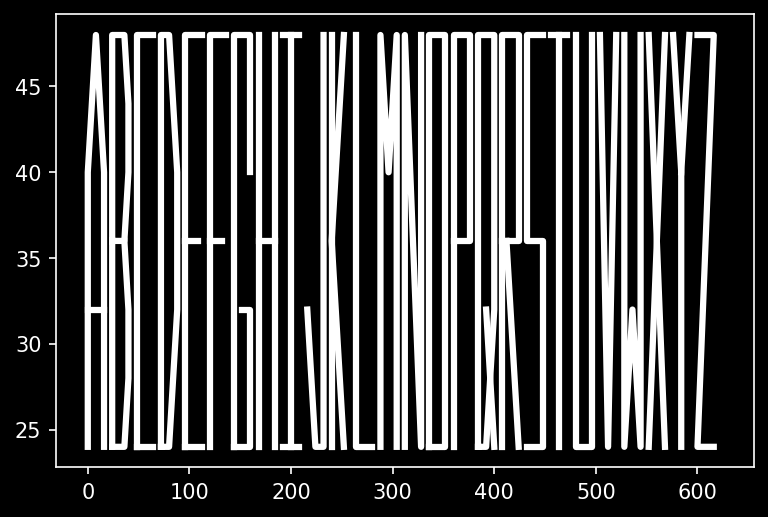

In [129]:
import re
anvgan = open("../tempest_fun/src/ANVGAN.MAC",'r').read()
letters = [tuple(x.split(':')) for x in re.split('CHAR\.',anvgan)[1:27]]
letters = {x:y for x,y in letters}
vector_data = "\tVCTR 0,24,0\n"
for c, vec_data in letters.items():
    vector_data += vec_data
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


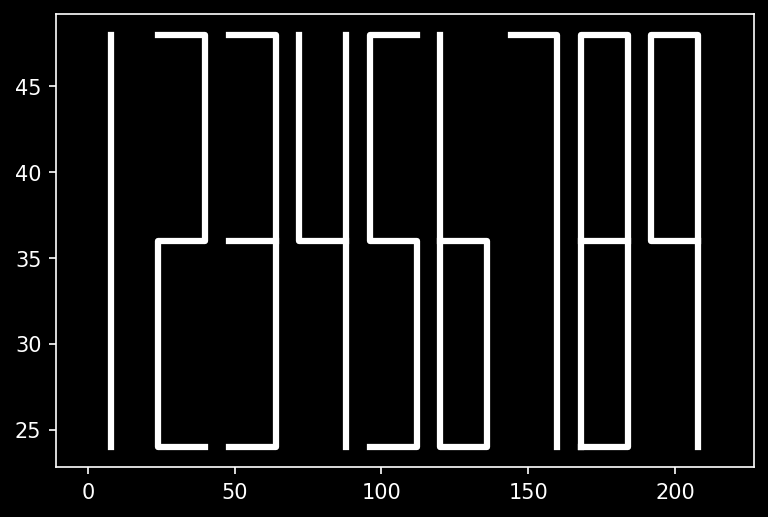

In [131]:
import re
anvgan = open("../tempest_fun/src/ANVGAN.MAC",'r').read()
numbers = [tuple(x.split(':'))[:2] for x in re.split('CHAR\.',anvgan)[30:39]]
numbers = {x:y for x,y in numbers}
vector_data = "\tVCTR 0,24,0\n"
for c, vec_data in numbers.items():
    vector_data += vec_data
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


In [133]:
vector_data = "VCTR 0,24,0\n"
word = "ALIEN SPACE GAME"
for c in word:
    vector_data += letters[c]
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")

KeyError: ' '

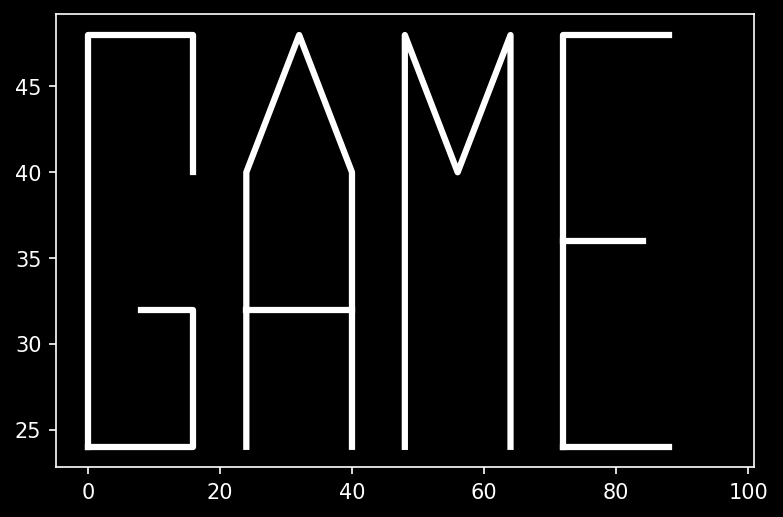

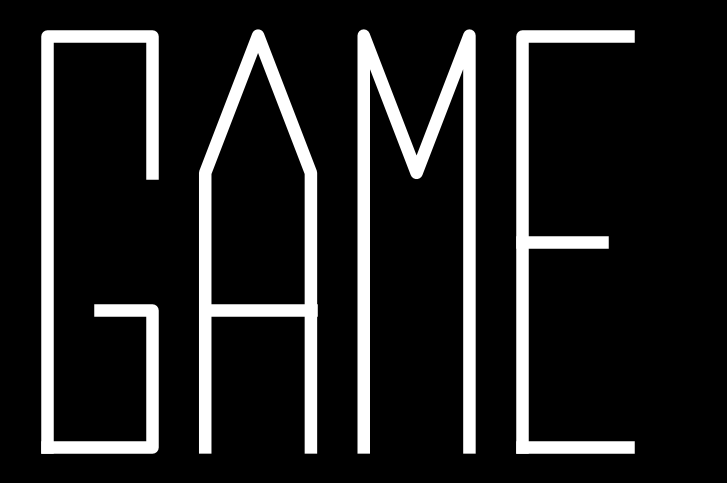

In [137]:
vector_data = "VCTR 0,24,0\n"
word = "GAME"
for c in word:
    vector_data += letters[c]
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")
plot_vertices_imgonly(vertices,"alien",points="",linewidth=6.0)

## Mysterious Unused Stuff in ALVROM.MAC

There is more unused stuff related to the discard 'Space Game' predecessor.

Not immediately obvious what this stuff is:
```
ASTTBL:	
    .BYTE ENDAST-ASTTBL
	.BYTE -6,0,0
	.BYTE 3,5,4
	.BYTE 3,5,-4
	.BYTE 0,-5,0
```

The comments say vertices:
```
	.SBTTL OBJECT TABLES - VERTICES
```

So let's try that. Unlike everything else we've looked at so far these appear to be
x,y,z vertices.

[0, 1, 2, 3, 0, 2, 3, 1]
[(-6, 0, 0), (3, 5, 4), (3, 5, -4), (0, -5, 0)]
[[(-6, 0, 0), (3, 5, 4), (3, 5, -4), (0, -5, 0), (-6, 0, 0), (3, 5, -4)], [(0, -5, 0), (3, 5, 4)]]


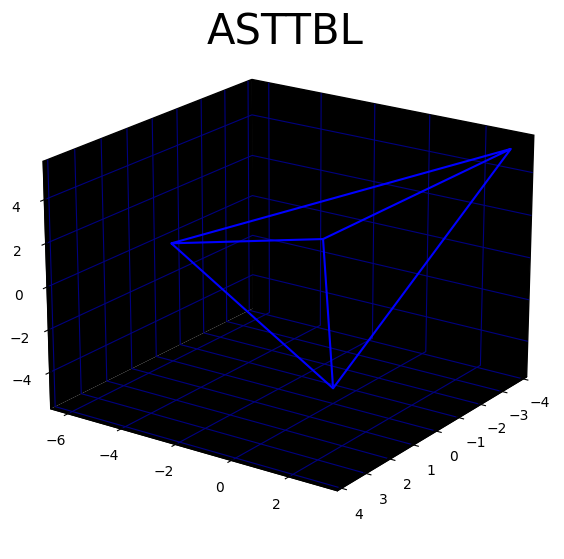

In [289]:
import numpy as np
def plotMult3DVertices(mult_vertices,titlename=""):
    #Change the Size of Graph using Figsize
    plt.style.use('default')
    plt.rcParams['grid.color'] = "navy"
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')
    for verts in mult_vertices:
        x = np.array([[x for x,y,z in verts]])
        y = np.array([y for _,y,_ in verts])
        z = np.array([[z for x,y,z in verts]])

        ax.plot_wireframe(x,y,z, color ='blue')
        ax.view_init(azim=35,elev=20,vertical_axis="y")
    ax.xaxis.set_pane_color("black")
    ax.yaxis.set_pane_color("black")
    ax.zaxis.set_pane_color("black")
    plt.title(titlename,y=1,fontsize = 30)

"""
These appear to be commands that reference the table below by their index.
So we'll store it is a list of indices.
"""
indices = [int(x.strip().split()[1]) for x in """
ASTDRW:
	TLABS 0
	SBRITE 0E0
	TVCTR 1
	TVCTR 2
	TVCTR 3
	TVCTR 0
	TVCTR 2
	SBRITE 0
	TVCTR 3
	SBRITE 0E0
	TVCTR 1
	OBJEND
""".splitlines()[2:] if "TVCTR" in x or "TLABS" in x]
print(indices)

"""
Each entry in our list of indices is an index into this table,
which we'll treat as an array of x,y,z co-ordinates.
"""
table = """
ASTTBL:	
    .BYTE ENDAST-ASTTBL
	.BYTE -6,0,0
	.BYTE 3,5,4
	.BYTE 3,5,-4
	.BYTE 0,-5,0
"""

# Split our table into a list of x,y,z vertices.
vertices = [
    (int(x.split()[1].split(',')[0]),
     int(x.split()[1].split(',')[1]),
     int(x.split()[1].split(',')[2]))
     for x in table.splitlines()[3:]]
print(vertices)

# Now use the indices to create a a list of the x,y,z
# vertices in the order specified by ASTDRW
vertices = [vertices[i] for i in indices]

# Manually split it to respect the 'SBRITE 0' lines, which
# are telling us that no line should be drawn between two
# vertices.
verts = [vertices[:6],vertices[-2:]]
print(verts)

# Plot
plotMult3DVertices(verts,"ASTTBL")



That seems to work. Let's try it for the rest of them. First we'll do the sequence of 'enemy spears'. Presumably these were enemy bullets. There's more than one because they were used in animation sequence.

[0, 1, 0, 2, 0, 3]
[(0, -5, 0), (2, 5, 0), (-1, 5, 2), (-1, 5, -2)]
[((0, -5, 0), (2, 5, 0)), ((0, -5, 0), (-1, 5, 2)), ((0, -5, 0), (-1, 5, -2))]
[(0, -5, 0), (2, 5, 1), (-2, 5, 1), (0, 5, -2)]
[((0, -5, 0), (2, 5, 1)), ((0, -5, 0), (-2, 5, 1)), ((0, -5, 0), (0, 5, -2))]
[(0, -5, 0), (1, 5, 2), (-2, 5, 0), (1, 5, -2)]
[((0, -5, 0), (1, 5, 2)), ((0, -5, 0), (-2, 5, 0)), ((0, -5, 0), (1, 5, -2))]
[(0, -5, 0), (0, 5, 2), (-2, 5, -1), (2, 5, -1)]
[((0, -5, 0), (0, 5, 2)), ((0, -5, 0), (-2, 5, -1)), ((0, -5, 0), (2, 5, -1))]


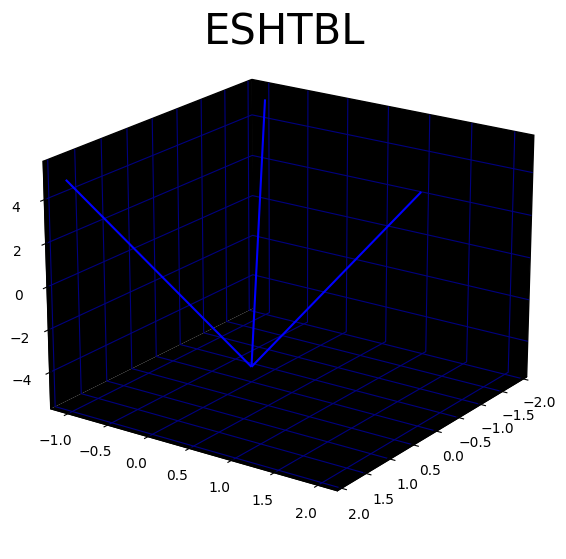

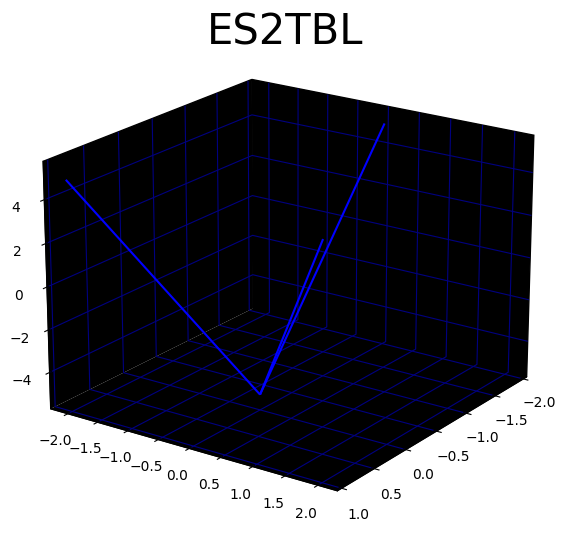

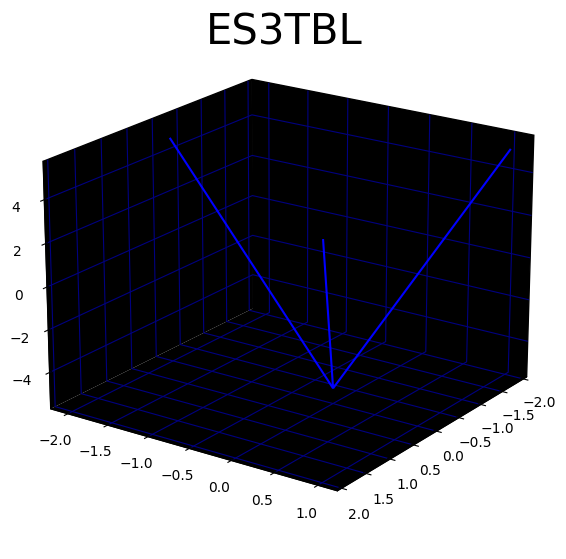

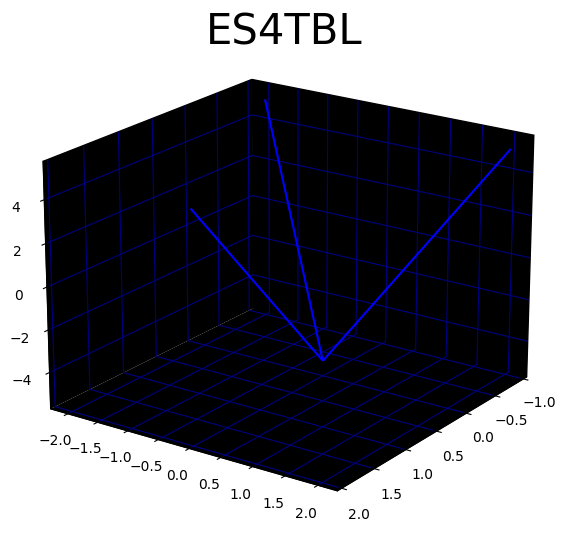

In [290]:
indices = [int(x.strip().split()[1]) for x in """
ESHDRW:	
    TLABS 0
	SBRITE 0E0
	TVCTR 1
	SBRITE 0
	TVCTR 0
	SBRITE 0E0
	TVCTR 2
	SBRITE 0
	TVCTR 0
	SBRITE 0E0
	TVCTR 3
	OBJEND
""".splitlines()[2:] if "TVCTR" in x or "TLABS" in x]
print(indices)

tables = ["""
ESHTBL:	
    .BYTE ENDESH-ESHTBL
	.BYTE 0,-5,0
	.BYTE 2,5,0
	.BYTE -1,5,2
	.BYTE -1,5,-2
""","""
ES2TBL:	
    .BYTE EN2ESH-ES2TBL
	.BYTE 0,-5,0
	.BYTE 2,5,1
	.BYTE -2,5,1
	.BYTE 0,5,-2
""","""
ES3TBL:
    .BYTE EN3ESH-ES3TBL
	.BYTE 0,-5,0
	.BYTE 1,5,2
	.BYTE -2,5,0
	.BYTE 1,5,-2
""","""
ES4TBL:	
    .BYTE EN4ESH-ES4TBL
	.BYTE 0,-5,0
	.BYTE 0,5,2
	.BYTE -2,5,-1
	.BYTE 2,5,-1
"""]

for table in tables:
    vertices = [
        (int(x.split()[1].split(',')[0]),
         int(x.split()[1].split(',')[1]),
         int(x.split()[1].split(',')[2]))
         for x in table.splitlines()[3:]]
    print(vertices)
    title = table.splitlines()[1].strip()[:-1]
    vertices = [vertices[i] for i in indices]
    verts = list(zip(vertices[::2],vertices[1::2]))
    print(verts)
    plotMult3DVertices(verts,title)


Now we will do the player's spear (or bullet). It seems to resemble a scatterjack. As with the enemy spear there's a set of four giving us an animation.

[0, 1, 2, 3, 4, 5]
[(-2, 0, 2), (2, 0, -2), (-2, 0, -2), (2, 0, 2), (0, 2, 0), (0, -2, 0)]
[((-2, 0, 2), (2, 0, -2)), ((-2, 0, -2), (2, 0, 2)), ((0, 2, 0), (0, -2, 0))]
[(-2, 1, 1), (2, -1, -1), (-2, -1, -1), (2, 1, 1), (0, 1, -1), (0, -1, 1)]
[((-2, 1, 1), (2, -1, -1)), ((-2, -1, -1), (2, 1, 1)), ((0, 1, -1), (0, -1, 1))]
[(-2, 2, 0), (2, -2, 0), (-2, -2, 0), (2, 2, 0), (0, 0, -2), (0, 0, 2)]
[((-2, 2, 0), (2, -2, 0)), ((-2, -2, 0), (2, 2, 0)), ((0, 0, -2), (0, 0, 2))]
[(-2, 1, -1), (2, -1, 1), (-2, -1, 1), (2, 1, -1), (0, -1, -1), (0, 1, 1)]
[((-2, 1, -1), (2, -1, 1)), ((-2, -1, 1), (2, 1, -1)), ((0, -1, -1), (0, 1, 1))]


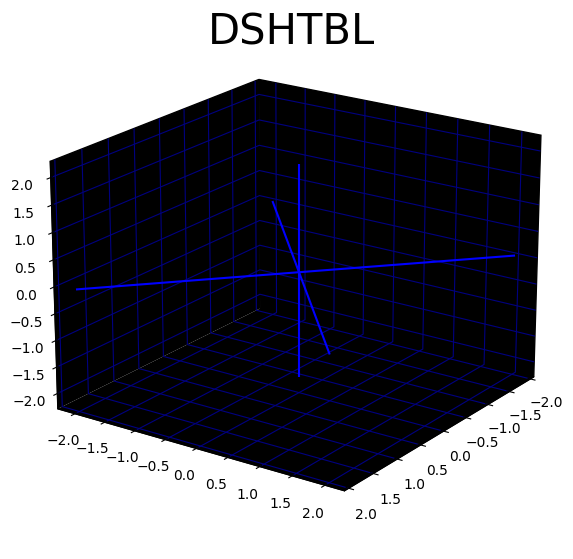

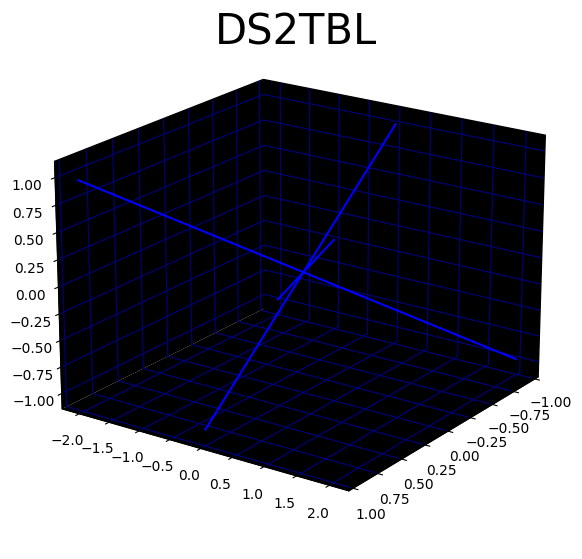

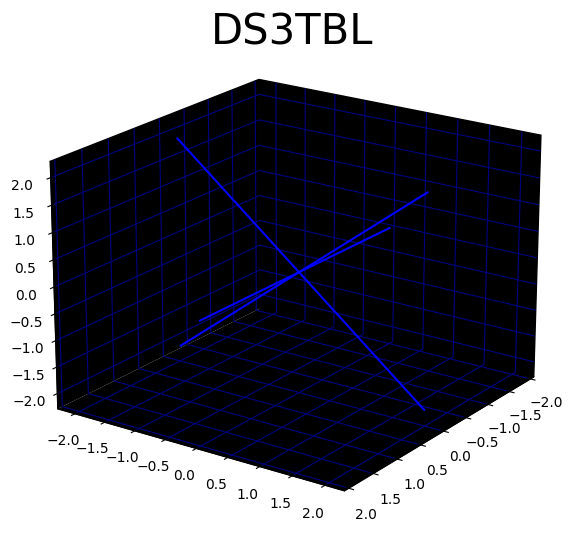

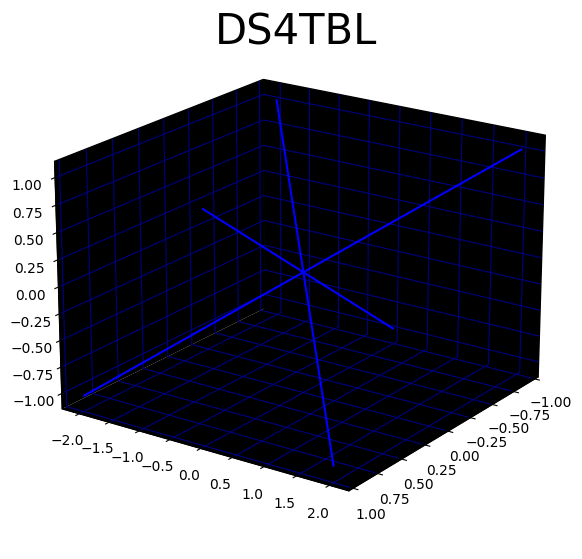

In [291]:
indices = [int(x.strip().split()[1]) for x in """
DSHDRW:	
    TLABS 0
	SBRITE 0E0
	TVCTR 1
	SBRITE 0
	TVCTR 2
	SBRITE 0E0
	TVCTR 3
	SBRITE 0
	TVCTR 4
	SBRITE 0E0
	TVCTR 5
	OBJEND
""".splitlines()[2:] if "TVCTR" in x or "TLABS" in x]
print(indices)


tables = ["""
DSHTBL:	
    .BYTE ENDDSH-DSHTBL
	.BYTE -2,0,2
	.BYTE 2,0,-2
	.BYTE -2,0,-2
	.BYTE 2,0,2
	.BYTE 0,2,0
	.BYTE 0,-2,0
""","""
DS2TBL:	
    .BYTE ENDDS2-DS2TBL
	.BYTE -2,1,1
	.BYTE 2,-1,-1
	.BYTE -2,-1,-1
	.BYTE 2,1,1
	.BYTE 0,1,-1
	.BYTE 0,-1,1
""","""
DS3TBL:	
    .BYTE ENDDS3-DS3TBL
	.BYTE -2,2,0
	.BYTE 2,-2,0
	.BYTE -2,-2,0
	.BYTE 2,2,0
	.BYTE 0,0,-2
	.BYTE 0,0,2
""","""
DS4TBL:	
    .BYTE ENDDS4-DS4TBL
	.BYTE -2,1,-1
	.BYTE 2,-1,1
	.BYTE -2,-1,1
	.BYTE 2,1,-1
	.BYTE 0,-1,-1
	.BYTE 0,1,1
"""]

for table in tables:
    vertices = [
        (int(x.split()[1].split(',')[0]),
         int(x.split()[1].split(',')[1]),
         int(x.split()[1].split(',')[2]))
         for x in table.splitlines()[3:]]
    print(vertices)
    
    title = table.splitlines()[1].strip()[:-1]

    vertices = [vertices[i] for i in indices]
    verts = list(zip(vertices[::2],vertices[1::2]))
    print(verts)
    plotMult3DVertices(verts,title)
